In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from EDA_plots import *
from plot_style import *
path = 'data'

In [4]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

store_sales = pd.read_csv(
    path + '/train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

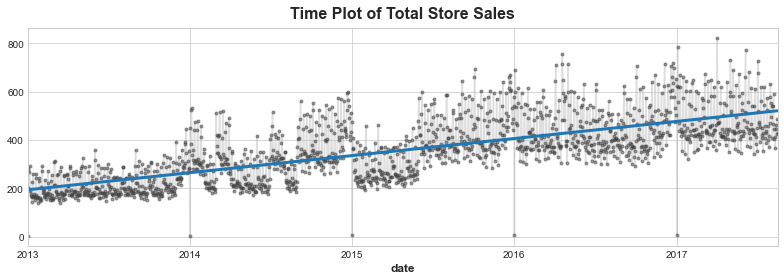

In [5]:
df = average_sales.to_frame()

time = np.arange(len(df.index))  # time dummy

df['time'] = time

X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

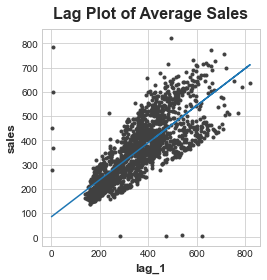

In [6]:
# linear regression model with a lag feature on the series of average product sales
df = average_sales.to_frame()

lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1

X = df.loc[:, ['lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'sales']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

#### Exploring trends

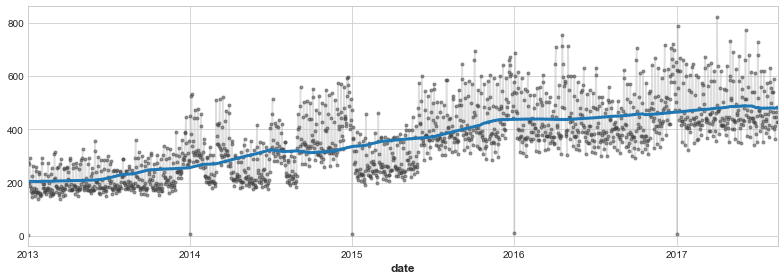

In [7]:
# moving average plot of average_sales estimating the trend.

trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

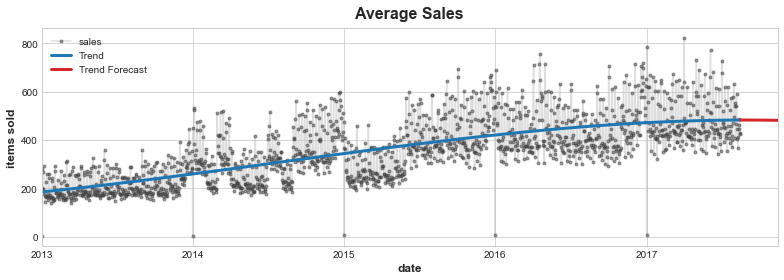

In [8]:
# DeterministicProcess to create a feature set for a cubic trend model.
y = average_sales.copy()  # the target

dp = DeterministicProcess(index=y.index, order=3)
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

One way to fit more complicated trends is to increase the order of the polynomial we use. To get a better fit to the somewhat complicated trend in data, we could try using an order 11 polynomial.

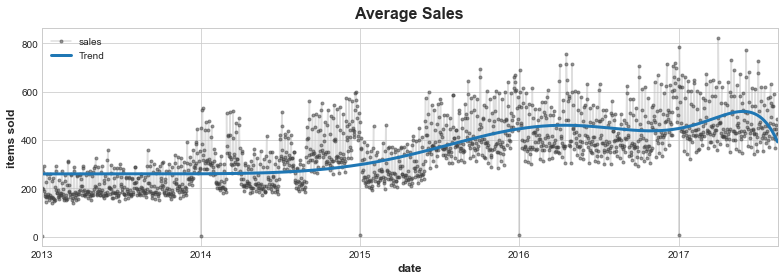

In [9]:
dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

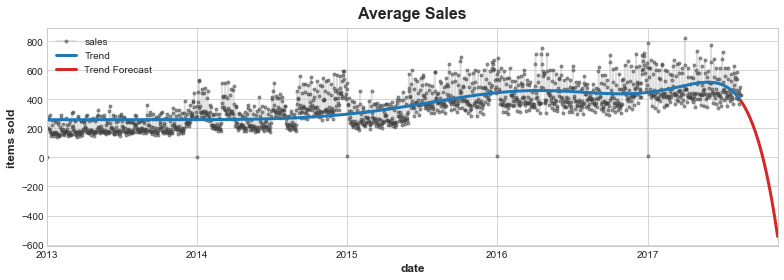

In [11]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

In conclusionh high-order polynomials are generally not well-suited to forecasting. An order 11 polynomial will include terms like t ** 11. Terms like these tend to diverge rapidly outside of the training period making forecasts very unreliable

##### Seasonality features 

In [63]:
holidays_events = pd.read_csv(
    path +"/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    path +'/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017'] # exploring just 2017 since it takes long for computing the whole data
)

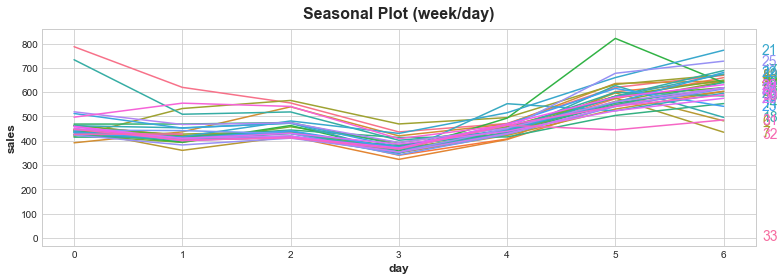

In [57]:
# seasonal plot

X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

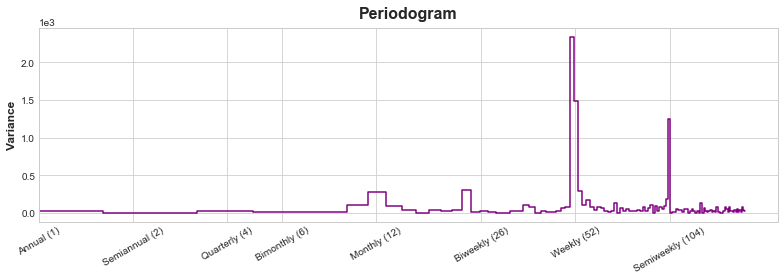

In [45]:
plot_periodogram(average_sales);

Both the seasonal plot and the periodogram suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

Using DeterministicProcess and CalendarFourier to create:

- indicators for weekly seasons and
- Fourier features of order 4 for monthly seasons.

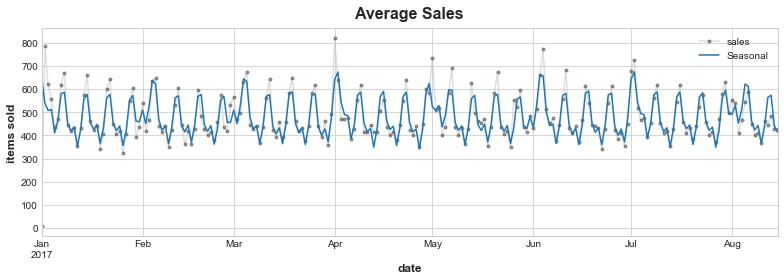

In [46]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

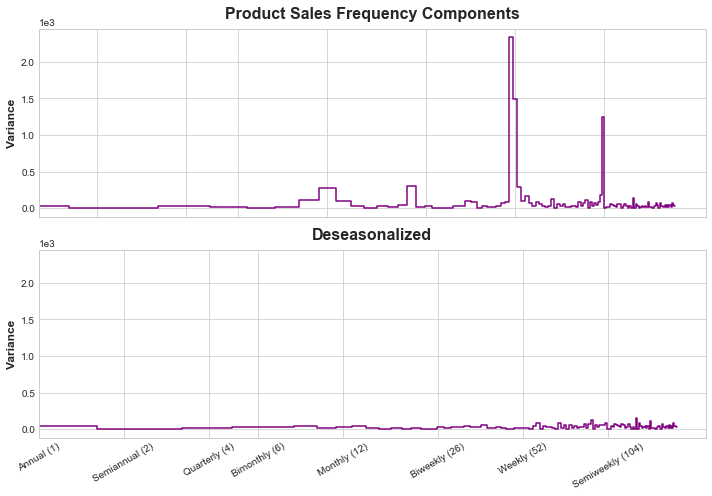

In [47]:
# periodogram of the deseasonalized series.
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales

In [60]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)
display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


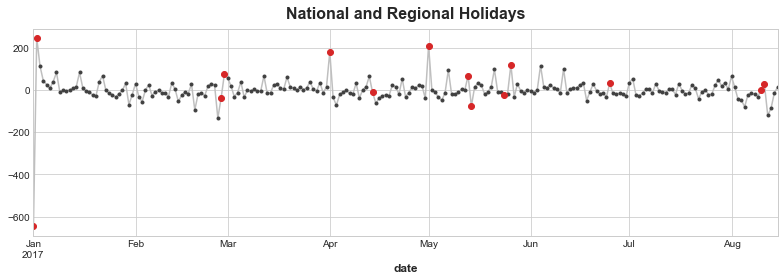

In [59]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

From a plot of the deseasonalized Average Sales, it appears these holidays could have some predictive power

In [61]:
from sklearn.preprocessing import OneHotEncoder
# Creating holiday features

ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

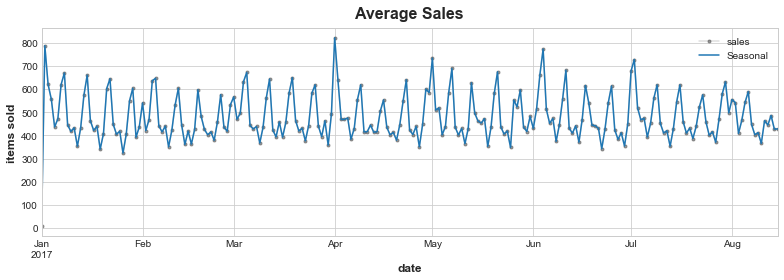

In [62]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

With Onehot encoding the model predicts the holidays pretty well

In [64]:
# sales amounts during the holidays
y.loc[y.index.isin(holidays.index)]

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-02-27    418.045410
2017-02-28    532.753540
2017-04-01    821.034790
2017-04-14    415.762909
2017-05-01    733.276855
2017-05-13    626.810852
2017-05-14    496.184021
2017-05-24    418.801147
2017-05-26    552.475403
2017-06-25    613.137390
2017-08-10    365.536987
2017-08-11    463.733856
Freq: D, Name: sales, dtype: float32

In [71]:
df3 = pd.concat([y,y_pred,y_pred-y],axis=1)
df3.columns = ['ground_truth','predictions','residuals']
df3.loc[df3.index.isin(holidays.index)].round(3)

,ground_truth,predictions,residuals
date,,,
2017-01-01,6.780000,6.780,0.0
2017-01-02,786.927979,786.928,-0.0
2017-02-27,418.045013,418.045,0.0
2017-02-28,532.754028,532.754,-0.0
2017-04-01,821.034973,821.035,-0.0
2017-04-14,415.763000,415.763,0.0
2017-05-01,733.276978,733.277,-0.0
2017-05-13,626.810974,626.811,-0.0
2017-05-14,496.183990,496.184,0.0


With onehot encodeing the model has too much flexibility and literally memorises the values for each date. We can see from the above dataframe the model is preforming pretty well.

##### Lag features for store sales

In [72]:
store_sales = pd.read_csv(
    path+'/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

mag_sales = family_sales.loc(axis=1)[:, 'MAGAZINES']

Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of magazines, however, show patterns of growth and decay not well characterized by trend or seasons.
Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely cyclic behavior, we'll start by deseasonalizing the series.

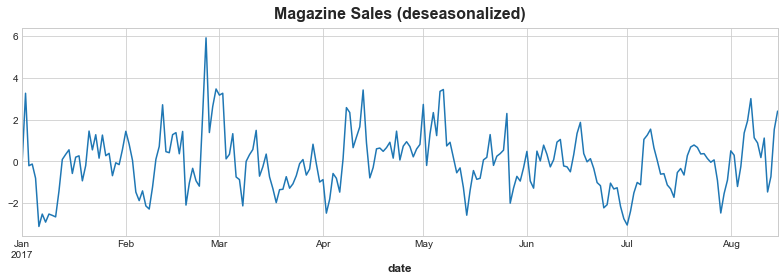

In [74]:
y = mag_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Magazine Sales (deseasonalized)");

Does this deseasonalized series show cyclic patterns? To confirm our intuition, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.

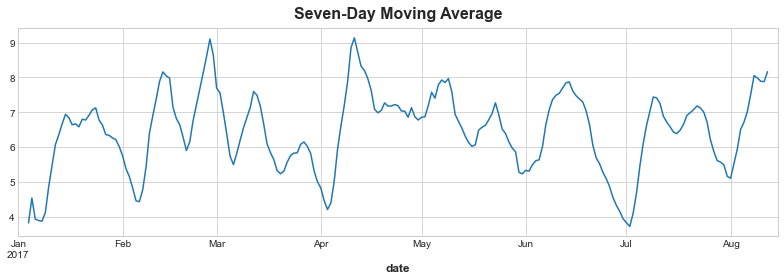

In [75]:
# Creating a seven-day moving average from y, the series of magazine sales.
# Using a centered window, not setting the min_periods argument.

y_ma = y.rolling(7, center=True).mean()

ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

The moving average plot resembles the plot of the deseasonalized series. In both, we can see cyclic behavior indicated.

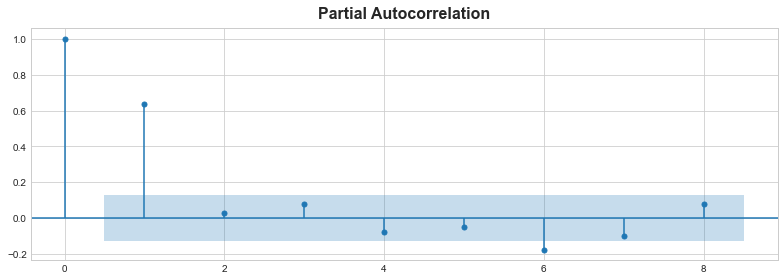

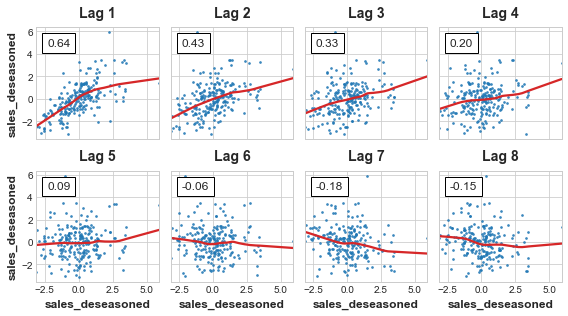

In [76]:
# Let's examine our deseasonalized series for serial dependence.

plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

The correlogram indicates the first lag is likely to be significant, as well as possibly the sixth lag. The lag plot suggests some non-linear effect as well.

- We know  leading indicator is a series whose values at one time can be used to predict the target at a future time -- a leading indicator provides "advance notice" of changes in the target.
- The dataset includes a time series that could potentially be useful as a leading indicator -- the onpromotion series, which contains the number of items on a special promotion that day. Since the company itself decides when to do a promotion, there's no worry about "lookahead leakage"; we could use Tuesday's onpromotion value to forecast sales on Monday, for instance.

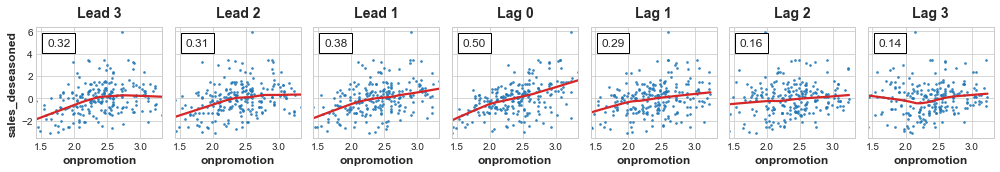

In [77]:
onpromotion = mag_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop the New Year outlier
plot_lags(x=onpromotion.iloc[1:], y=y_deseason.iloc[1:], lags=3, leads=3, nrows=1);

The lag plot indicates that both leading and lagged values of onpromotion are correlated with magazine sales. This suggests that both kinds of values could be useful as features.
In addition, the leading values seem to have some non-linear effect.

In [78]:
# time series features
X_lags = make_lags(y_deseason, lags=1)

X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)

X_oil = pd.DataFrame()

X = pd.concat([X_time, X_lags, X_promo, X_oil], axis=1).dropna()
y, X = y.align(X, join='inner')

Training RMSLE: 0.11025
Validation RMSLE: 0.10031


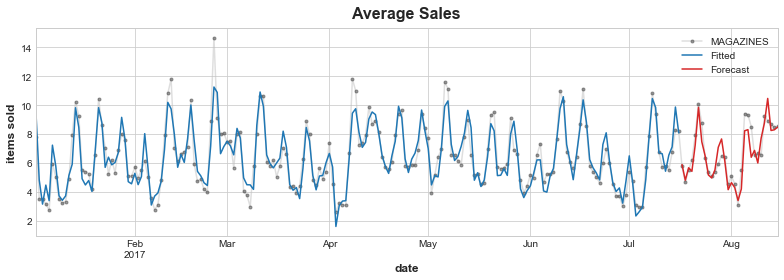

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

This model includes moving averages and other rolling statistics in their feature sets. Such features seem to be especially useful when used with GBDT algorithms like XGBoost.